In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import shap
from ctgan import CTGAN

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import matplotlib.pyplot as plt

mlflow.set_tracking_uri("http://localhost:5000")

# Explorative Data Analysis

In [ ]:
# df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
# profile = ProfileReport(df, title="Flats -  Würzburg - Rent - Overview", explorative=True)
# profile.to_file("eda-wue-rent-all.html")

In [ ]:
# df = pd.read_excel(r'data\houses_to_buy_wue_preprocessed_1207.xlsx')
# profile = ProfileReport(df, title="Houses -  Würzburg - Buy - Overview", explorative=True)
# profile.to_file("eda-wue-houses.html")

# Preprocessing & Feature Engineering


In [ ]:
def determineHighCorrCols(df):
    df.columns = [
        re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col)
        for col in df.columns
    ]
    df.columns = [
        col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss")
        for col in df.columns
    ]
    important_num_cols = list(
        df.corr()["Object_price"][
            (df.corr()["Object_price"] > 0.20) | (df.corr()["Object_price"] < -0.20)
        ].index
    )
    cat_cols = [col for col in df.columns if df[col].dtype == "object"]
    important_cols = important_num_cols + cat_cols + ["ConstructionYear"] + ["ZipCode"]
    print(important_cols)
    return important_cols

In [109]:
def preprocess_data(df, feature_set):
    print(f"Used feature set for preprocessing:{feature_set}")
    df.columns = [
        re.sub(r"\\u([0-9a-fA-F]{4})", lambda m: chr(int(m.group(1), 16)), col)
        for col in df.columns
    ]
    df.columns = [
        col.replace("ö", "oe").replace("ä", "ae").replace("ü", "ue").replace("ß", "ss")
        for col in df.columns
    ]

    df = df.replace('""', np.nan)
    df = df.dropna()
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df["Rooms"] = df["Rooms"].astype(float)
    df["ZipCode"] = df["ZipCode"].astype(str)
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df = df[feature_set]
    df = df.reindex()
    df = df.reset_index(drop=True)
    cat_cols = [col for col in df.columns if df[col].dtype == "object"]
    y = df["Object_price"]
    X = df.drop("Object_price", axis=1)
    X = pd.get_dummies(X, columns=cat_cols)

    return X, y

# Data Split


In [110]:
def data_split(X, y, train_size=0.8, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, train_size=train_size, random_state=random_state
    )

    # X_train.to_excel("data/X_train.xlsx")
    # X_val.to_excel("data/X_val.xlsx")
    # X_test.to_excel("data/X_test.xlsx")
    # y_train.to_excel("data/y_train.xlsx")
    # y_val.to_excel("data/y_val.xlsx")
    # y_test.to_excel("data/y_test.xlsx")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Training, Evaluation and Logging Of Models

## Baseline 

In [ ]:
def scrape_avg_rental_prices():
    url = "https://www.wohnungsboerse.net/mietspiegel-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    script_tag = soup.find("script", string=lambda text: "pdfData" in text)
    rental_price = 0
    if script_tag:
        script_content = script_tag.string
        start_index = script_content.find("avg_rent_price: ") + len("avg_rent_price: '")
        end_index = script_content.find("',", start_index)
        rental_price = script_content[start_index:end_index]
        rental_price = (
            rental_price.replace("€/m2", "").replace(".", "").replace(",", ".")
        )
        rental_price = rental_price.strip()
        rental_price = float(rental_price)
        print(f"Extrcated rental price per square meter via scraper: {rental_price}")
    else:
        print("The script tag containing the rental price was not found.")
    return rental_price

In [ ]:
def scrape_avg_buy_prices():
    url = "https://www.wohnungsboerse.net/immobilienpreise-Wuerzburg/2772"
    response = requests.get(url)
    response.raise_for_status(
    )
    soup = BeautifulSoup(response.text, "html.parser")
    p_element = soup.find("p", class_="mb-8")
    buy_price = 0
    if p_element:
        pattern = r"\d{1,3}(?:\.\d{3})*(?:,\d{2})?€/m²"
        match = re.search(pattern, p_element.text)
        if match:
            buy_price = match.group()
            buy_price = buy_price.replace("€/m²", "").replace(".", "").replace(",", ".")
            print(f"Extrcated buy price per square meter via scraper: {buy_price}")
        else:
            print("Price not found")
    else:
        print("The element ontaining the buy price was not found.")
    return buy_price

In [ ]:
def baseline_rent(val_X, val_y, runname="baseline_rent"):
    avg_price_per_sqm_rent = scrape_avg_rental_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_rent}")
    return avg_price_per_sqm_rent

In [ ]:
def baseline_buy(X_val, y_val, runname="baseline_buy"):
    avg_price_per_sqm_buy = scrape_avg_buy_prices()
    print(f"Average rental price per sqm: {avg_price_per_sqm_buy}")

    baseline_preds = X_val["LivingSpace"] * avg_price_per_sqm_buy
    baseline_mae = mean_absolute_error(y_val, baseline_preds)
    baseline_r2 = r2_score(y_val, baseline_preds)
    baseline_mse = mean_squared_error(y_val, baseline_preds)

    with mlflow.start_run(run_name=runname):
        mlflow.log_metric("mse", baseline_mse)
        mlflow.log_metric("mae", baseline_mae)
        mlflow.log_metric("r2", baseline_r2)

    print(f"Baseline Mae: {baseline_mae}")
    print(f"Baseline MSE: {baseline_mse}")
    print(f"Baseline R2 Score: {baseline_r2}")

    return avg_price_per_sqm_buy, baseline_mae, baseline_mse, baseline_r2

## Regression (Linear, Lasso, Ridge)

In [ ]:
def train_and_eval_linear(X_train, y_train, X_val, y_val, runname="linear-regression"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_and_eval_lasso(X_train, y_train, X_val, y_val, runname="lasso-regression"):
    model = Lasso()
    model.fit(X_train, y_train)
    return model

def train_and_eval_ridge(X_train, y_train, X_val, y_val, runname="ridge-regression"):
    model = Ridge()
    model.fit(X_train, y_train)
    return model

## Random Forest

In [ ]:
def train_and_eval_rf(
    X_train,
    y_train,
    X_val,
    y_val,
    n_estimators=50,
    random_state=0,
    run_name="random-forest",
):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

## XGBRegressor


In [ ]:
def train_and_eval_xgb(
    X_train,
    y_train,
    X_val,
    y_val,
    run_name="xgb",
    early_stopping_rounds=30,
    max_depth=6,
    n_estimators=1000,
):
    model = xgb.XGBRegressor(
        eval_metric=["rmse", "mae"],
        early_stopping_rounds=early_stopping_rounds,
        random_state=42,
        max_depth=max_depth,
        n_estimators=n_estimators,
    )

    model.fit(X=X_train, y=y_train, eval_set=[(X_val, y_val)], verbose=True)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    shap.plots.waterfall(shap_values[6])
    plt.savefig("waterfall_0.png", bbox_inches="tight")
    shap.plots.waterfall(shap_values[5])
    plt.savefig("waterfall_1.png", bbox_inches="tight")
    shap.plots.waterfall(shap_values[9])
    plt.savefig("waterfall_2.png", bbox_inches="tight")
    shap.plots.waterfall(shap_values[10])
    plt.savefig("waterfall_3.png", bbox_inches="tight")
    shap.plots.beeswarm(shap_values)
    plt.savefig("beeswarm.png", bbox_inches="tight")

    return model

## ElasticNet

In [ ]:
def train_and_eval_elasticnet(X_train, y_train, X_val, y_val, runname="elasticNet"):
    model = ElasticNet()
    model.fit(X_train, y_train)
    return model

# Complete Pipeline

### Regular Pipeline

In [ ]:
def pipeline_from_extracted(df, feature_set, model_name="lasso"):
    mlflow.end_run()
    model = None
    X, y = preprocess_data(df, feature_set)
    print("Done with preprocessing")
    X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y)
    print("Done with data split")

    if model_name == "xgb":
        mlflow.xgboost.autolog()
    else:
        mlflow.sklearn.autolog()

    with mlflow.start_run(run_name=model_name):
        model, mae, mse, r2, mae_train, mse_train, r2_train = (
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        )

        if model_name == "lasso":
            model = train_and_eval_lasso(X_train, y_train, X_val, y_val)
        elif model_name == "ridge":
            model = train_and_eval_ridge(X_train, y_train, X_val, y_val)
        elif model_name == "rf":
            model = train_and_eval_rf(X_train, y_train, X_val, y_val)
        elif model_name == "xgb":
            model = train_and_eval_xgb(X_train, y_train, X_val, y_val)
        elif model_name == "elasticnet":
            model = train_and_eval_elasticnet(X_train, y_train, X_val, y_val)
        elif model_name == "linear":
            model = train_and_eval_linear(X_train, y_train, X_val, y_val)
        elif model_name == "baseline-rent":
            avg_price = baseline_rent(X_val, y_val)
            baseline_preds = X_val["LivingSpace"] * avg_price
            baseline_preds_test = X_test["LivingSpace"] * avg_price
            mlflow.log_metric("mae", mean_absolute_error(y_val, baseline_preds))
            mlflow.log_metric("mse", mean_squared_error(y_val, baseline_preds))
            mlflow.log_metric("r2", r2_score(y_val, baseline_preds))
            mlflow.log_metric(
                "mae_test", mean_absolute_error(y_test, baseline_preds_test)
            )
            mlflow.log_metric(
                "mse_test", mean_squared_error(y_test, baseline_preds_test)
            )
            mlflow.log_metric("r2_test", r2_score(y_test, baseline_preds_test))
            return model, mae, mse, r2, mae_train, mse_train, r2_train
        else:
            print(
                "Model not found. Model_name must be 'lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline_buy' or 'baseline_rent' or conigure the pipeline manually."
            )

        pred_train = model.predict(X_train)
        preds = model.predict(X_val)
        pred_test = model.predict(X_test)

        mlflow.log_metric("mae_test", mean_absolute_error(y_test, pred_test))
        mlflow.log_metric("mse_test", mean_squared_error(y_test, pred_test))
        mlflow.log_metric("r2_test", r2_score(y_test, pred_test))

        mlflow.log_metric("mae_train", mean_absolute_error(y_train, pred_train))
        mlflow.log_metric("mse_train", mean_squared_error(y_train, pred_train))
        mlflow.log_metric("r2_train", r2_score(y_train, pred_train))

        mlflow.log_metric("mae", mean_absolute_error(y_val, preds))
        mlflow.log_metric("mse", mean_squared_error(y_val, preds))
        mlflow.log_metric("r2", r2_score(y_val, preds))

    print("Done with train")
    mlflow.end_run()
    return model, mae, mse, r2, mae_train, mse_train, r2_train

### Augmented Data Approach with CTGan

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.autolog(disable=True)


def complete_from_extracted_with_augemented_training_data(
    df,
    feature_set,
    model_name,
    augmentation_epochs=30,
    n_added_fake_train_data=1000,
):
    df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")

    df = df.replace('""', np.nan)
    df = df.dropna()
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df["Rooms"] = df["Rooms"].astype(float)
    # df = df.dropna(subset=["ConstructionYear"])
    # df = df.dropna(subset=["Object_price"])
    # df = df.dropna(subset=["Rooms"])
    # df = df.dropna(subset=["LivingSpace"])
    df["ZipCode"] = df["ZipCode"].astype(str)
    df["LivingSpace"] = df["LivingSpace"].astype(float)
    df = df[feature_set]
    df = df.reindex()
    df = df.reset_index(drop=True)
    X = df.drop(columns=["Object_price"])
    y = df["Object_price"]

    X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y)

    train = pd.concat([X_train, y_train], axis=1)
    val = pd.concat([X_val, y_val], axis=1)

    df_cttrain = train.copy()
    df_cttrain = df_cttrain.dropna()

    numerical_features = ["Rooms", "LivingSpace", "Object_price"]

    df_cttrain[numerical_features] = df_cttrain[numerical_features].astype("int64")
    categorical_features = [
        col for col in df_cttrain.columns if col not in numerical_features
    ]
    ctgan = CTGAN(verbose=True)
    ctgan.fit(df_cttrain, categorical_features, epochs=augmentation_epochs)

    samples = ctgan.sample(n_added_fake_train_data * 3)
    samples["Object_price"] = samples["Object_price"].clip(lower=0)
    samples = samples[samples["LivingSpace"] > 20]
    samples = samples[samples["Object_price"] > 120]
    samples = samples.head(n_added_fake_train_data)

    X_sample_train = samples.drop(columns=["Object_price"])
    y_sample_train = samples["Object_price"]
    X_train = pd.concat([X_train, X_sample_train])
    y_train = pd.concat([y_train, y_sample_train])

    # train_extended = pd.concat(
    #     [X_train, y_train], axis=1
    # )

    # X_train, y_train = preprocess_data(train_extended, feature_set_selected)
    # X_val, y_val = preprocess_data(val, feature_set_selected)

    X_train_cat_cols = [
        col for col in X_train.columns if X_train[col].dtype == "object"
    ]
    X_train = pd.get_dummies(X_train, columns=X_train_cat_cols)

    X_val_cat_cols = [col for col in X_val.columns if X_val[col].dtype == "object"]
    X_val = pd.get_dummies(X_val, columns=X_val_cat_cols)

    print(f"X_val shape: {X_val.shape}")
    print(f"val shape: {val.shape}")
    print(f"X_val head: {X_train.head()}")
    print(f"val head: {val.head()}")

    X_train, X_val = X_train.align(X_val, join="outer", axis=1, fill_value=0)

    model, mae, mse, r2, mae_train, mse_train, r2_train = (
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    )

    if model_name == "lasso":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_lasso(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "ridge":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_ridge(
            X_train,
            y_train,
            X_val,
            y_val,
        )
    elif model_name == "rf":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_rf(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "xgb":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_xgb(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "elasticnet":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_elasticnet(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "linear":
        model, mae, mse, r2, mae_train, mse_train, r2_train = train_and_eval_linear(
            X_train, y_train, X_val, y_val
        )
    elif model_name == "baseline-rent":
        avg_price, mae, mse, r2 = baseline_rent(X_val, y_val)
    else:
        print(
            "Model not found. Model_name must be 'lasso', 'ridge', 'rf', 'xgb', 'elasticnet', 'linear', 'baseline_buy' or 'baseline_rent'"
        )
    print("Done with train")
    return model, mae, mse, r2, mae_train, mse_train, r2_train

# Execution of complete pipeline

In [ ]:
df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")
feature_set_high_corr = determineHighCorrCols(df) + ["ZipCode"]

Starting with model:  baseline-rent
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split
Extrcated rental price per square meter via scraper: 11.21
Average rental price per sqm: 11.21
Done with model:  baseline-rent
---------------------------------------------------------------------------
Starting with model:  lasso
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizu

2023/07/14 14:59:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 14:59:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  lasso
---------------------------------------------------------------------------
Starting with model:  ridge
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split


2023/07/14 14:59:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 15:00:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  ridge
---------------------------------------------------------------------------
Starting with model:  xgb
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split
[0]	validation_0-rmse:975.49976	validation_0-mae:845.57492
[1]	validation_0-rmse:749.26720	validation_0-mae:618.15297
[2]	validation_0-rmse:599.25921	validation_0-mae:474.74173
[3]	validation_0-rmse:482.26499	validation_0-mae:358.96303
[4]	validation_0-rmse:414.90881	validation_0-mae:302.03719
[5]	validation_0-rmse:366.23603	validation_0-mae:264.90933
[6]	validation_0-rmse:336.23308	validation_0-mae:243.57824
[7]	validation_

2023/07/14 15:01:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


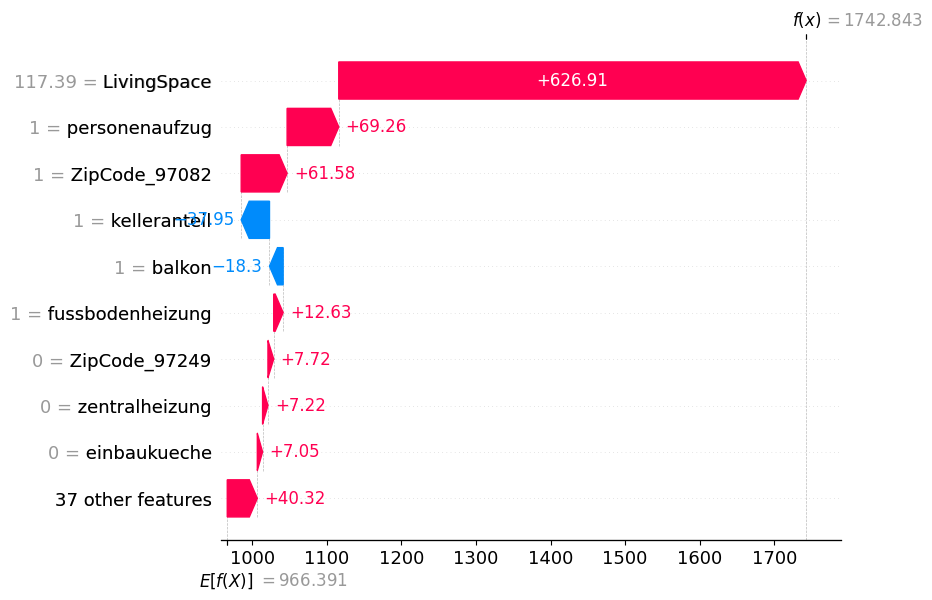

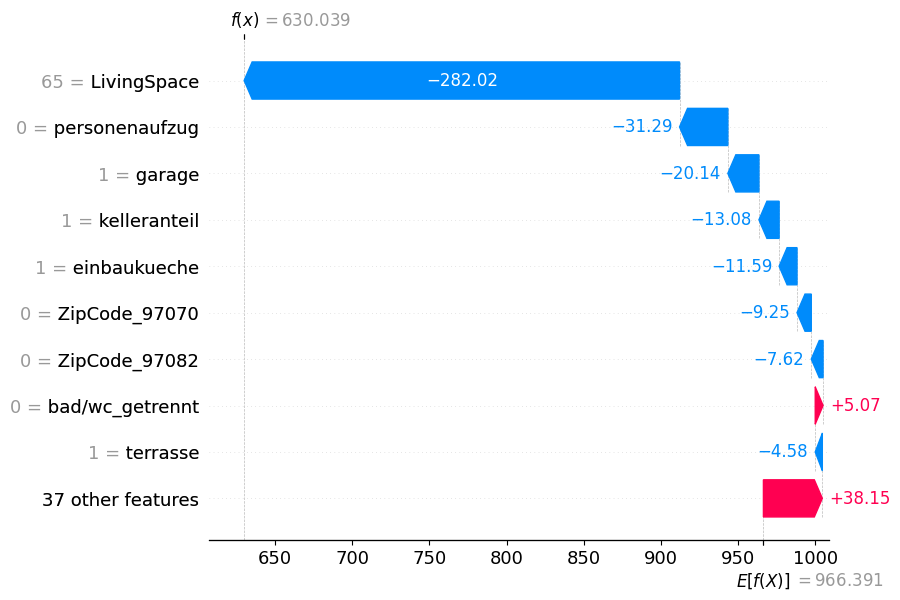

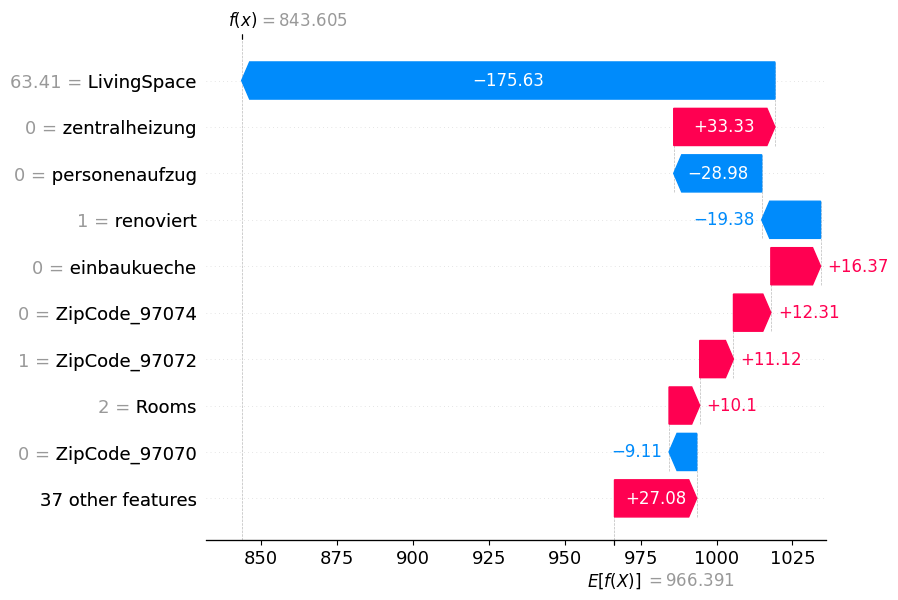

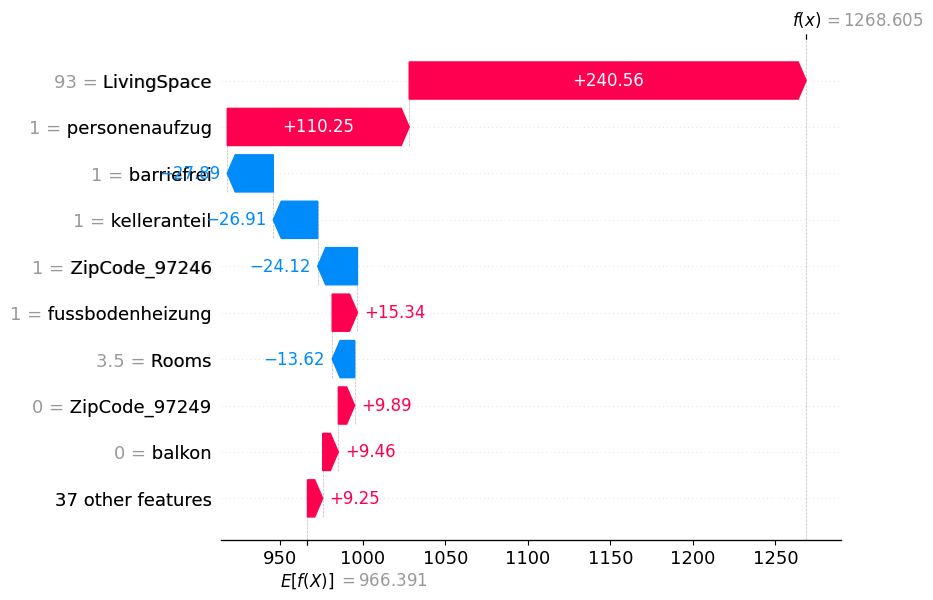

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


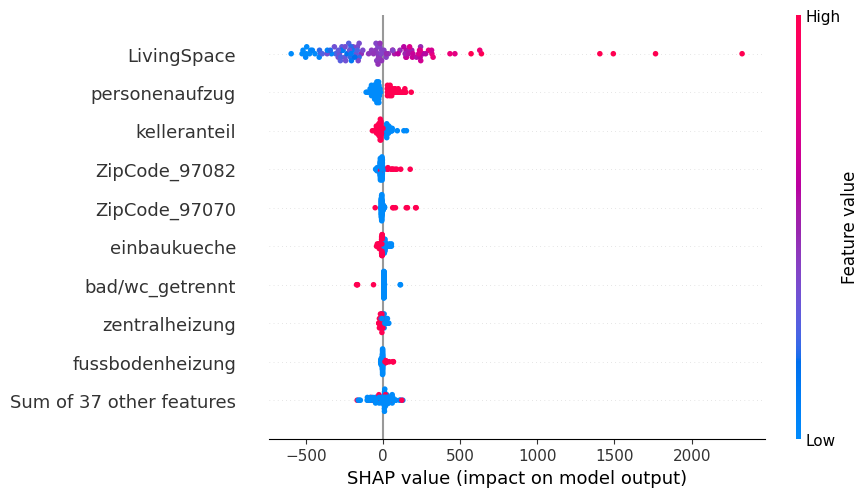

2023/07/14 15:01:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 15:01:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  xgb
---------------------------------------------------------------------------
Starting with model:  rf
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split


2023/07/14 15:01:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 15:01:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  rf
---------------------------------------------------------------------------
Starting with model:  elasticnet
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split


2023/07/14 15:02:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 15:02:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  elasticnet
---------------------------------------------------------------------------
Starting with model:  linear
Used feature set for preprocessing:['Object_price', 'LivingSpace', 'ZipCode', 'Rooms', 'altbau_(bis_1945)', 'balkon', 'barriefrei', 'dachgeschoss', 'einbaukueche', 'neubau', 'parkett', 'stellplatz', 'bad/wc_getrennt', 'personenaufzug', 'garten', 'garage', 'renoviert', 'terrasse', 'wanne', 'zentralheizung', 'abstellraum', 'ferne', 'fussbodenheizung', 'gartennutzung', 'kelleranteil']
Done with preprocessing
Done with data split


2023/07/14 15:03:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\envs\enterpriseai2\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/14 15:03:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\michi\Anaconda3\env

Done with train
Done with model:  linear
---------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [111]:
df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")
mlflow.set_experiment("wue-rent-selected-features-14-07-org")
model_names = ["baseline-rent", "lasso", "ridge", "xgb" , "rf", "elasticnet", "linear"]
n_added_fake_train_data = 120
feature_set_selected = [
    "Object_price",
    "LivingSpace",
    "ZipCode",
    "Rooms",
    "altbau_(bis_1945)",
    "balkon",
    "barriefrei",
    "dachgeschoss",
    "einbaukueche",
    "neubau",
    "parkett",
    "stellplatz",
    "bad/wc_getrennt",
    "personenaufzug",
    "garten",
    "garage",
    "renoviert",
    "terrasse",
    "wanne",
    "zentralheizung",
    "abstellraum",
    "ferne",
    "fussbodenheizung",
    "gartennutzung",
    "kelleranteil",
]

for model_name in model_names:
    mlflow.end_run()
    df = pd.read_excel(r"data\flats_to_rent_wue_preprocessed_combined.xlsx")
    print("Starting with model: ", model_name)
    pipeline_from_extracted(df, model_name=model_name, feature_set=feature_set_selected)
    print("Done with model: ", model_name)
    print("---------------------------------------------------------------------------")

In [ ]:
## With Data Augementation
# for model_name in model_names:
#     df = pd.read_excel(r'data\flats_to_rent_wue_preprocessed_combined.xlsx')
#     print("Starting with model: ", model_name)
#     complete_from_extracted_with_augemented_training_data(df, model_name=model_name, feature_set=feature_set_selected, n_added_fake_train_data=0)
#     print("Done with model: ", model_name)
#     print("-------------------------------------------------------------------------")

## Get all runs and make result plots

In [ ]:
results_selected_features = mlflow.search_runs(
    experiment_names=["wue-rent-selected-features"]
)
results_selected_features = results_selected_features[
    ["tags.mlflow.runName", "metrics.mae", "metrics.r2"]
]
results_selected_features = results_selected_features.sort_values(
    by="metrics.mae", ascending=False
)
results_selected_features["experiment"] = "wue-rent-selected-features"

results_selected_features_aug_50 = mlflow.search_runs(
    experiment_names=["wue-rent-selected-features-aug-50"]
)
results_selected_features_aug_50 = results_selected_features_aug_50[
    ["tags.mlflow.runName", "metrics.mae", "metrics.r2"]
]
results_selected_features_aug_50 = results_selected_features_aug_50.sort_values(
    by="metrics.mae", ascending=False
)
results_selected_features_aug_50["experiment"] = "wue-rent-selected-features-aug-50"

results_selected_features_aug_120 = mlflow.search_runs(
    experiment_names=["wue-rent-selected-features-aug-120"]
)
results_selected_features_aug_120 = results_selected_features_aug_120[
    ["tags.mlflow.runName", "metrics.mae", "metrics.r2"]
]
results_selected_features_aug_120 = results_selected_features_aug_120.sort_values(
    by="metrics.mae", ascending=False
)
results_selected_features_aug_120["experiment"] = "wue-rent-selected-features-aug-120"

results_selected_features_aug_1000 = mlflow.search_runs(
    experiment_names=["wue-rent-selected-features-aug-1000"]
)
results_selected_features_aug_1000 = results_selected_features_aug_1000[
    ["tags.mlflow.runName", "metrics.mae", "metrics.r2"]
]
results_selected_features_aug_1000 = results_selected_features_aug_1000.sort_values(
    by="metrics.mae", ascending=False
)
results_selected_features_aug_1000["experiment"] = "results-selected-features-aug-1000"

results_selected_features_aug_comparison = pd.concat(
    [
        results_selected_features,
        results_selected_features_aug_50,
        results_selected_features_aug_120,
        results_selected_features_aug_1000,
    ]
)
results_selected_features_aug_comparison.to_excel("results-selected-features-aug.xlsx")
print(results_selected_features_aug_comparison)

In [ ]:
df = pd.read_excel(r"results-selected-features-aug.xlsx")

linear_regression_data = df[df["tags.mlflow.runName"] == "linear-regression"]
lasso_regression_data = df[df["tags.mlflow.runName"] == "lasso-regression"]
ridge_regression_data = df[df["tags.mlflow.runName"] == "ridge-regression"]
xgb_data = df[df["tags.mlflow.runName"] == "xgb"]
random_forest_data = df[df["tags.mlflow.runName"] == "random-forest"]
elasticnet_data = df[df["tags.mlflow.runName"] == "elasticNet"]

linear_setups = linear_regression_data["experiment"]
linear_mae_values = linear_regression_data["metrics.mae"]
lasso_setups = lasso_regression_data["experiment"]
lasso_mae_values = lasso_regression_data["metrics.mae"]
ridge_setups = ridge_regression_data["experiment"]
ridge_mae_values = ridge_regression_data["metrics.mae"]
xgb_setups = xgb_data["experiment"]
xgb_mae_values = xgb_data["metrics.mae"]
random_forest_setups = random_forest_data["experiment"]
random_forest_mae_values = random_forest_data["metrics.mae"]
elasticnet_setups = elasticnet_data["experiment"]
elasticnet_mae_values = elasticnet_data["metrics.mae"]

linear_labels = [str(setup).split("-")[-1] for setup in linear_setups]
linear_labels = [
    "no augm." if label == "features" else label for label in linear_labels
]
lasso_labels = [str(setup).split("-")[-1] for setup in lasso_setups]
lasso_labels = ["no augm." if label == "features" else label for label in lasso_labels]
ridge_labels = [str(setup).split("-")[-1] for setup in ridge_setups]
ridge_labels = ["no augm." if label == "features" else label for label in ridge_labels]
xgb_labels = [str(setup).split("-")[-1] for setup in xgb_setups]
xgb_labels = ["no augm." if label == "features" else label for label in xgb_labels]
random_forest_labels = [str(setup).split("-")[-1] for setup in random_forest_setups]
random_forest_labels = [
    "no augm." if label == "features" else label for label in random_forest_labels
]
elasticnet_labels = [str(setup).split("-")[-1] for setup in elasticnet_setups]
elasticnet_labels = [
    "no augm." if label == "features" else label for label in elasticnet_labels
]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 6))

ax1.bar(linear_labels, linear_mae_values)
ax1.set_ylabel("MAE")
ax1.set_xlabel("n_augmented_data")
ax1.set_title("Linear Regression")
ax1.tick_params(axis="x", labelrotation=90)

ax2.bar(lasso_labels, lasso_mae_values)
ax2.set_ylabel("MAE")
ax2.set_xlabel("n_augmented_data")
ax2.set_title("Lasso Regression")
ax2.tick_params(axis="x", labelrotation=90)

ax3.bar(ridge_labels, ridge_mae_values)
ax3.set_ylabel("MAE")
ax3.set_xlabel("n_augmented_data")
ax3.set_title("Ridge Regression")
ax3.tick_params(axis="x", labelrotation=90)

ax4.bar(xgb_labels, xgb_mae_values)
ax4.set_ylabel("MAE")
ax4.set_xlabel("n_augmented_data")
ax4.set_title("XGBoost")
ax4.tick_params(axis="x", labelrotation=90)

ax5.bar(random_forest_labels, random_forest_mae_values)
ax5.set_ylabel("MAE")
ax5.set_xlabel("n_augmented_data")
ax5.set_title("Random Forest")
ax5.tick_params(axis="x", labelrotation=90)

ax6.bar(elasticnet_labels, elasticnet_mae_values)
ax6.set_ylabel("MAE")
ax6.set_xlabel("n_augmented_data")
ax6.set_title("ElasticNet")
ax6.tick_params(axis="x", labelrotation=90)

plt.suptitle("Data Augmentation with CTGAN has a negative impact on MAE", fontsize=16)
plt.tight_layout()

plt.savefig("regression_results.png")
plt.show()